In [98]:
!pip install python_speech_features
!pip install pycm

     |████████████████████████████████| 71kB 3.5MB/s 
     |████████████████████████████████| 573kB 7.8MB/s 


In [135]:
import os
import re
import string
import python_speech_features as mfcc
from scipy.io.wavfile import read
from glob import glob
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy
import random
from statistics import mode
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from pycm import *
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)

## Multinomial Logistic Regression from Scratch

In [266]:
def get_MFCC(audio, sr):
    features = mfcc.mfcc(audio, sr, 0.025, 0.01, 13, appendEnergy = True)
    return np.mean(features, axis=0)

In [267]:
def read_file(path):
  stock_files=sorted(glob(path))
  corpus=[]
  for file_path in stock_files:
    sr, audio = read(file_path)
    features = get_MFCC(audio, sr)
    corpus.append(features)
  return corpus

In [268]:
def generate_data(path,path2):
  temp=read_file(path)
  temp2=read_file(path2)
  male=pd.DataFrame(temp)
  female=pd.DataFrame(temp2)
  male['Gender']=1
  female['Gender']=0
  final=pd.concat([male,female],ignore_index=True)
  labels=final['Gender']
  final.drop('Gender', inplace=True, axis=1)
  final=final.to_numpy()
  labels=labels.to_numpy()
  return final,labels

In [269]:
def read_file_multiclass(path):
  names = [os.path.basename(x) for x in glob(path)]
  stock_files=sorted(glob(path + '/*'))
  corpus=[]
  labels=[]
  for file_path in stock_files:
    check=re.split(r'/[0-9]|/10',file_path)
    check=re.split(r'/SPK',check[0])
    check=re.split(r'_M|_F',check[1])
    check=int(check[0])
    labels.append(check)
    sr, audio = read(file_path)
    features = get_MFCC(audio, sr)
    corpus.append(features)
  return corpus,labels

In [270]:
def generate_data_multiclass(path):
  feature,label=read_file_multiclass(path)
  df=pd.DataFrame(feature)
  labels=pd.DataFrame(label)
  df=df.to_numpy()
  labels=labels.to_numpy()
  labels.astype(int)
  return df,labels.flatten()

In [271]:
def oneHot(y):
  y_oneHot = (np.arange(np.max(y) + 1) == y[:, None]).astype(float)
  return y_oneHot

In [272]:
def softMax(z):
  return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T

In [273]:
def predict(X, weights, biases):
  scores = (X.dot(weights) + biases)
  return softMax(scores)

In [274]:
def assignLabel(probability):
  return probability.argmax(axis=1)

In [275]:
def crossEntropy(X, y, weights, biases):
  y_pred = predict(X, weights, biases)
  return -np.sum(np.log(y_pred) * (y), axis=1)

In [276]:
def cost(X, y, weights, biases):
  return np.mean(crossEntropy(X, y, weights, biases))

In [277]:
def batchGradientDescent(n, X, y, weights, biases, alpha, n_epoch):
  m = X.shape[0]
  y = oneHot(y)
  J = list()
  for epoch in range(n_epoch):
    for j in np.arange(n):
      y_pred = predict(X, weights, biases)
      diff = np.subtract(y_pred[:,j],y[:,j])
      mul = np.multiply(X.T, diff)
      summ = np.sum(mul, axis = 1)
      theta = summ*alpha*(1/m)
      weights[:,j] = weights[:,j] - theta
      biases[:,j] = biases[:,j] - alpha*((np.sum(diff))*(1/m))
    J.append(cost(X,y,weights,biases))
  return weights, biases, J


In [278]:
def evaluation(title, y_true, y_pred):
  print("\n"+title+"\n")

  cm = ConfusionMatrix(actual_vector=y_true, predict_vector=y_pred)
  cm.plot(cmap=plt.cm.Greens,number_label=True,plot_lib="matplotlib")
  plt.show()

  print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_true, y_pred)*100))
  print('Macro Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='macro')*100))
  print('Macro Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='macro')*100))
  print('Macro F1-score: {:.2f}\n'.format(f1_score(y_true, y_pred, average='macro')*100))

## Gender Classification

### Training

In [279]:
path='/content/Gender_Recognition/Train/*M/*'
path2='/content/Gender_Recognition/Train/*F/*'
X_train,y_train=generate_data(path,path2)

In [280]:
n_classes=2

In [281]:
weights = np.zeros((X_train.shape[1],n_classes), dtype= np.float64)
biases = np.zeros((1, n_classes), dtype= np.float64)

In [282]:
alpha = 0.01
n_epoch = 100

In [283]:
weights, biases, J = batchGradientDescent(n_classes, X_train, y_train, weights, biases, alpha, n_epoch)

###Validation

In [284]:
path='/content/Gender_Recognition/Valid/*M/*'
path2='/content/Gender_Recognition/Valid/*F/*'
X_valid,y_valid=generate_data(path,path2)

In [285]:
probabilities = predict(X_valid, weights, biases)

In [286]:
y_pred = assignLabel(probabilities)

In [287]:
print('\nGender Classification - Validation\n\nAccuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred)*100))


Gender Classification - Validation

Accuracy: 80.00



Text(0.5, 1.0, 'Gender Classification - Cost vs Epoch')

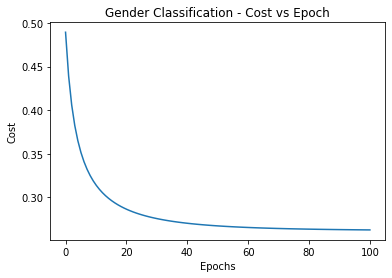

In [288]:
X=np.linspace(0, n_epoch, num=n_epoch)
J = np.array(J)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.plot(X, J)
plt.title('Gender Classification - Cost vs Epoch')

###Testing

In [289]:
path='/content/Gender_Recognition/Test/*M/*'
path2='/content/Gender_Recognition/Test/*F/*'
X_test,y_test=generate_data(path,path2)

In [290]:
probabilities = predict(X_test, weights, biases)

In [291]:
y_pred = assignLabel(probabilities)


Gender Classification - Testing



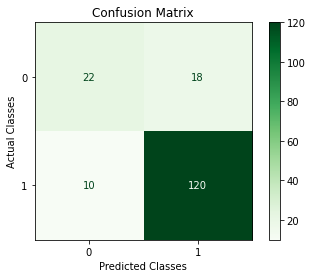


Accuracy: 83.53

Macro Precision: 77.85
Macro Recall: 73.65
Macro F1-score: 75.33



In [292]:
(evaluation("Gender Classification - Testing", y_test, y_pred))

## Speaker Recognition

### Training

In [293]:
path='/content/Speaker_Recognition/Train/*'
X_train,y_train=generate_data_multiclass(path)

In [294]:
n_classes = 143

In [295]:
weights = np.zeros((X_train.shape[1],n_classes), dtype= np.float64)
biases = np.zeros((1, n_classes), dtype= np.float64)

In [296]:
alpha = 0.01
n_epoch = 500

In [297]:
weights, biases, J = batchGradientDescent(n_classes, X_train, y_train, weights, biases, alpha, n_epoch)

### Validation

In [298]:
path='/content/Speaker_Recognition/Valid/*'
X_valid,y_valid=generate_data_multiclass(path)

In [299]:
probabilities = predict(X_valid, weights, biases)

In [300]:
y_pred = assignLabel(probabilities)

Text(0.5, 1.0, 'Speaker Recognition - Cost vs Epoch')

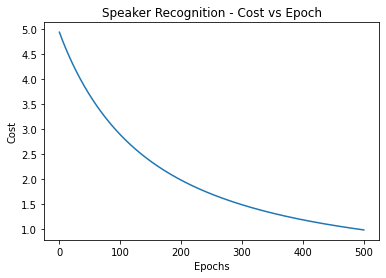

In [301]:
X=np.linspace(0, n_epoch, num=n_epoch)
J = np.array(J)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.plot(X, J)
plt.title('Speaker Recognition - Cost vs Epoch')

In [302]:
print('\nSpeaker Recognition - Validation\n\nAccuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred)*100))


Speaker Recognition - Validation

Accuracy: 92.96



### Testing

In [303]:
path='/content/Speaker_Recognition/Test/*'
X_test,y_test=generate_data_multiclass(path)

In [304]:
probabilities = predict(X_test, weights, biases)

In [305]:
y_pred = assignLabel(probabilities)


Speaker Recognition - Testing



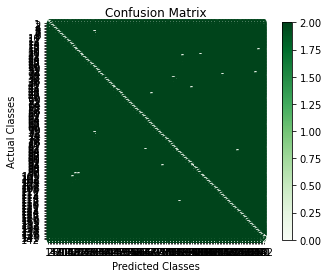


Accuracy: 93.66

Macro Precision: 94.84
Macro Recall: 93.66
Macro F1-score: 93.00



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [306]:
(evaluation("Speaker Recognition - Testing", y_test, y_pred))